# Solving 2D Poisson using fenics on brain image

- Fenics Tutorial vol I [link](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf)

#### Two strategies for building a mesh
(I still have to figure out which is the best)
1. Define mesh on the domain of interest [see here](https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/mesh-generation/python/documentation.html) (mesh generation has been moved to [another package](https://bitbucket.org/benjamik/mshr/src/master/) which I install in conda).
2. Define mesh on larger domain and set boundary condition on domain of interest (see [demos](https://fenicsproject.org/docs/dolfin/2018.1.0/python/demos.html) and [tutorial](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html)).

### Other link
- [post](https://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays) for nearest-neighbor interpolation.

In [1]:
import fenics as fe
import mshr
import cv2
import tlib.plot as tpl

ModuleNotFoundError: No module named 'fenics'

***
## Problem definition

In [2]:
# load image and contour
im = cv2.imread('./test.tif')

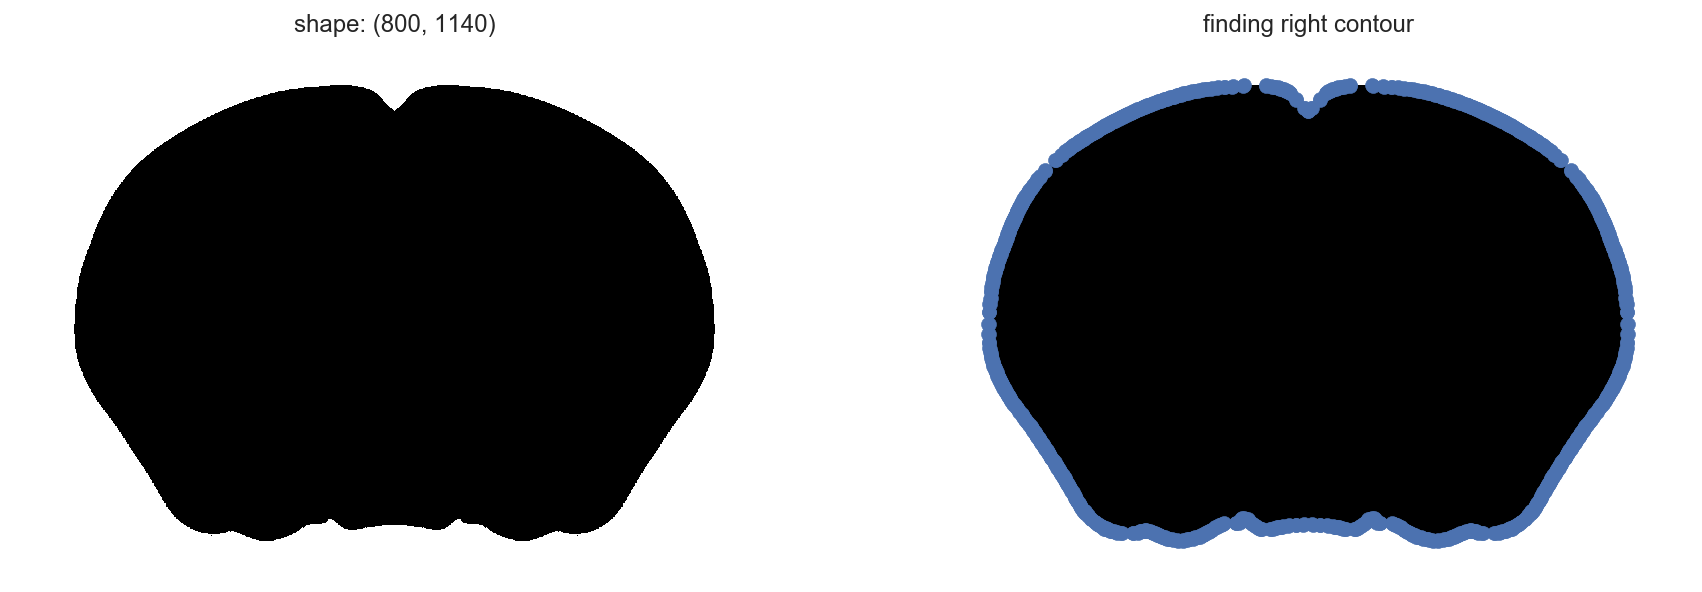

In [4]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(im, 1, 255, 0)
contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[2]  # by inspection
pts = np.reshape(contour, newshape=(-1, 2))
ys = pts[:, 0]
xs = pts[:, 1]
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0] = tpl.show_image(thresh, ax=axs[0])
axs[0].set_title('shape: ' + str(im.shape))
axs[1] = tpl.show_image(thresh, ax=axs[1])
axs[1].scatter(ys, xs);
axs[1].set_title('finding right contour');

In [5]:
# Generate mesh on domain
mesh_resolution = 30
pts_pp = [fe.Point(pt[0],  pt[1]) for pt in pts]
pts_pp = list(reversed(pts_pp))  # counter-clockwise order
pol = mshr.Polygon(pts_pp)
mesh = mshr.generate_mesh(pol, mesh_resolution)
mesh

In [6]:
# define function space on mesh
V = fe.FunctionSpace(mesh, 'P', 1)  

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [7]:
# formula must be written in C++ syntax
# u_D = fe.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
u_D = fe.Expression('0', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = fe.DirichletBC(V, u_D, boundary)

In [8]:
# cast to variational problem
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
f = fe.Constant(-6.0)
a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
L = f * v * fe.dx

***
## Solution

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


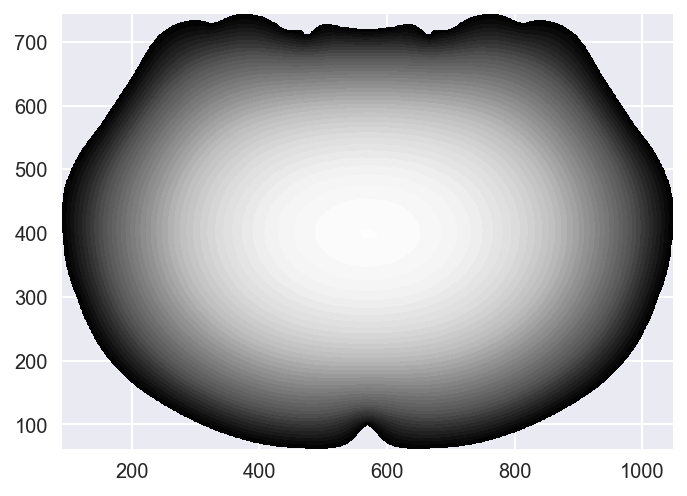

In [12]:
# Compute solution and display it
u = fe.Function(V)
fe.solve(a == L, u, bc)
fe.plot(u);

In [13]:
# Save solution to file in VTK format
vtkfile = fe.File('poisson/brain_image.pvd')
vtkfile << u

***
## In progress

In [10]:
from scipy import ndimage as nd

In [12]:
'Helpers'

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """
    # from 
    #import numpy as np
    #import scipy.ndimage as nd

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]


def convert_to_array(u, shape=im.shape):
    # define empty matrix with zeros
    sol = np.zeros(shape, dtype='float')
    # set equal to -1 points outside mesh
#     for y in tqdm(range(im.shape[0])):
#         for x in range(im.shape[1]):
#             if pol.inside(fe.Point(y, x)) is False:
#                 sol[y, x] = -1
    # assign values 
    vs = np.asarray(u.vector())
    ys = [pt[1] for pt in mesh.coordinates()]
    xs = [pt[0] for pt in mesh.coordinates()]

    for y, x, v in zip(ys, xs, vs):
        sol[int(y), int(x)] = v
    return sol

In [13]:
sol = convert_to_array(u, shape=im.shape)

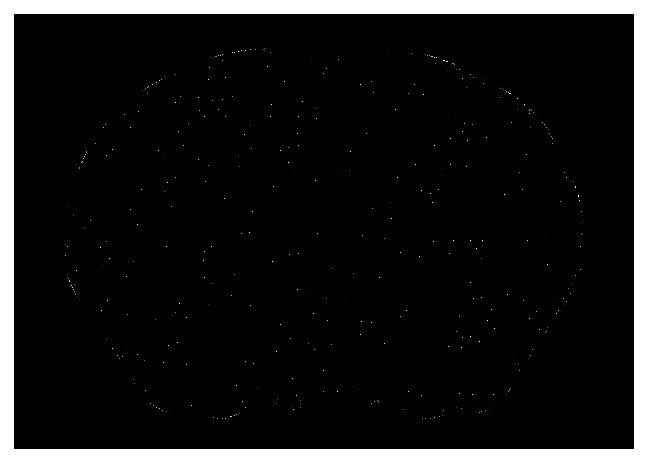

In [15]:
tpl.show_image(sol)

In [11]:
# Save solution to file in VTK format
vtkfile = fe.File('poisson/brain_image.pvd')
vtkfile << u

AttributeError: 'Argument' object has no attribute '_cpp_object'